What features are shared between nearest neighbors? Is it dominated by SNVs? CNAs? FDA approvals?

In [1]:
import sys
sys.path.append('../../common/')
import settings
settings.set_arial_as_font()

from settings import Colors

import pandas as pd

distances = pd.read_csv('tables/distances/snf_fda-cgc.stacked.txt', sep='\t', index_col=0)
distances = distances[~distances['case'].eq(distances['comparison'])]
distances.sort_values('snf_fda-cgc', ascending=True, inplace=True)

In [2]:
fda = pd.read_csv('tables/features/fda-features.boolean.txt', sep='\t', index_col='model_id')
cgc = pd.read_csv('tables/features/jaccard-cgc-feature-types.boolean.txt', sep='\t', index_col='model_id')

somatic = cgc.loc[:, cgc.columns[cgc.columns.str.contains('Somatic Variant')]]
cn = cgc.loc[:, cgc.columns[cgc.columns.str.contains('Copy Number')]]
fusion = cgc.loc[:, cgc.columns[cgc.columns.str.contains('Rearrangement')]]

In [3]:
items = []
columns = [
          'case', 'comparison',
          'n_fda', 'n_fda_shared_w_neighbor',
          'n_somatic', 'n_somatic_shared_w_neighbor',
          'n_cn', 'n_cn_shared_w_neighbor',
          'n_fusion', 'n_fusion_shared_w_neighbor'
          ]

for label, group in distances.groupby('case'):
    comparison = group.loc[group.index[0], 'comparison']
    
    series = pd.Series('', index=columns)
    series.loc['case'] = label
    series.loc['comparison'] = comparison
    series.loc['n_fda'] = fda.loc[label].sum()
    series.loc['n_somatic'] = somatic.loc[label].sum()
    series.loc['n_cn'] = cn.loc[label].sum()
    series.loc['n_fusion'] = fusion.loc[label].sum()
    
    series.loc['n_fda_shared_w_neighbor'] = fda.loc[[label, comparison]].sum().eq(2).sum()
    series.loc['n_somatic_shared_w_neighbor'] = somatic.loc[[label, comparison]].sum().eq(2).sum()
    series.loc['n_cn_shared_w_neighbor'] = cn.loc[[label, comparison]].sum().eq(2).sum()
    series.loc['n_fusion_shared_w_neighbor'] = fusion.loc[[label, comparison]].sum().eq(2).sum()
    
    series.loc['n'] = (
        series.loc[['n_fda', 'n_somatic', 'n_cn', 'n_fusion']].sum()
    )
      
    items.append(series)

In [4]:
group.head()

,case,comparison,snf_fda-cgc
142026,ACH-001190,ACH-000759,0.996835
141965,ACH-001190,ACH-000615,0.996912
142021,ACH-001190,ACH-000748,0.996916
142035,ACH-001190,ACH-000783,0.996956
142023,ACH-001190,ACH-000752,0.997005


In [5]:
df = pd.concat(items, axis=1).T
df.set_index('case', inplace=True)

In [6]:
df.head()

,comparison,n_fda,n_fda_shared_w_neighbor,n_somatic,n_somatic_shared_w_neighbor,n_cn,n_cn_shared_w_neighbor,n_fusion,n_fusion_shared_w_neighbor,n
case,,,,,,,,,,
ACH-000001,ACH-000893,1,1,13,3,188,24,9,0,211
ACH-000007,ACH-000504,0,0,30,0,22,6,0,0,52
ACH-000008,ACH-000450,1,1,17,2,29,16,0,0,47
ACH-000009,ACH-000759,0,0,22,2,84,43,1,0,107
ACH-000012,ACH-000491,3,2,9,2,15,3,2,1,29


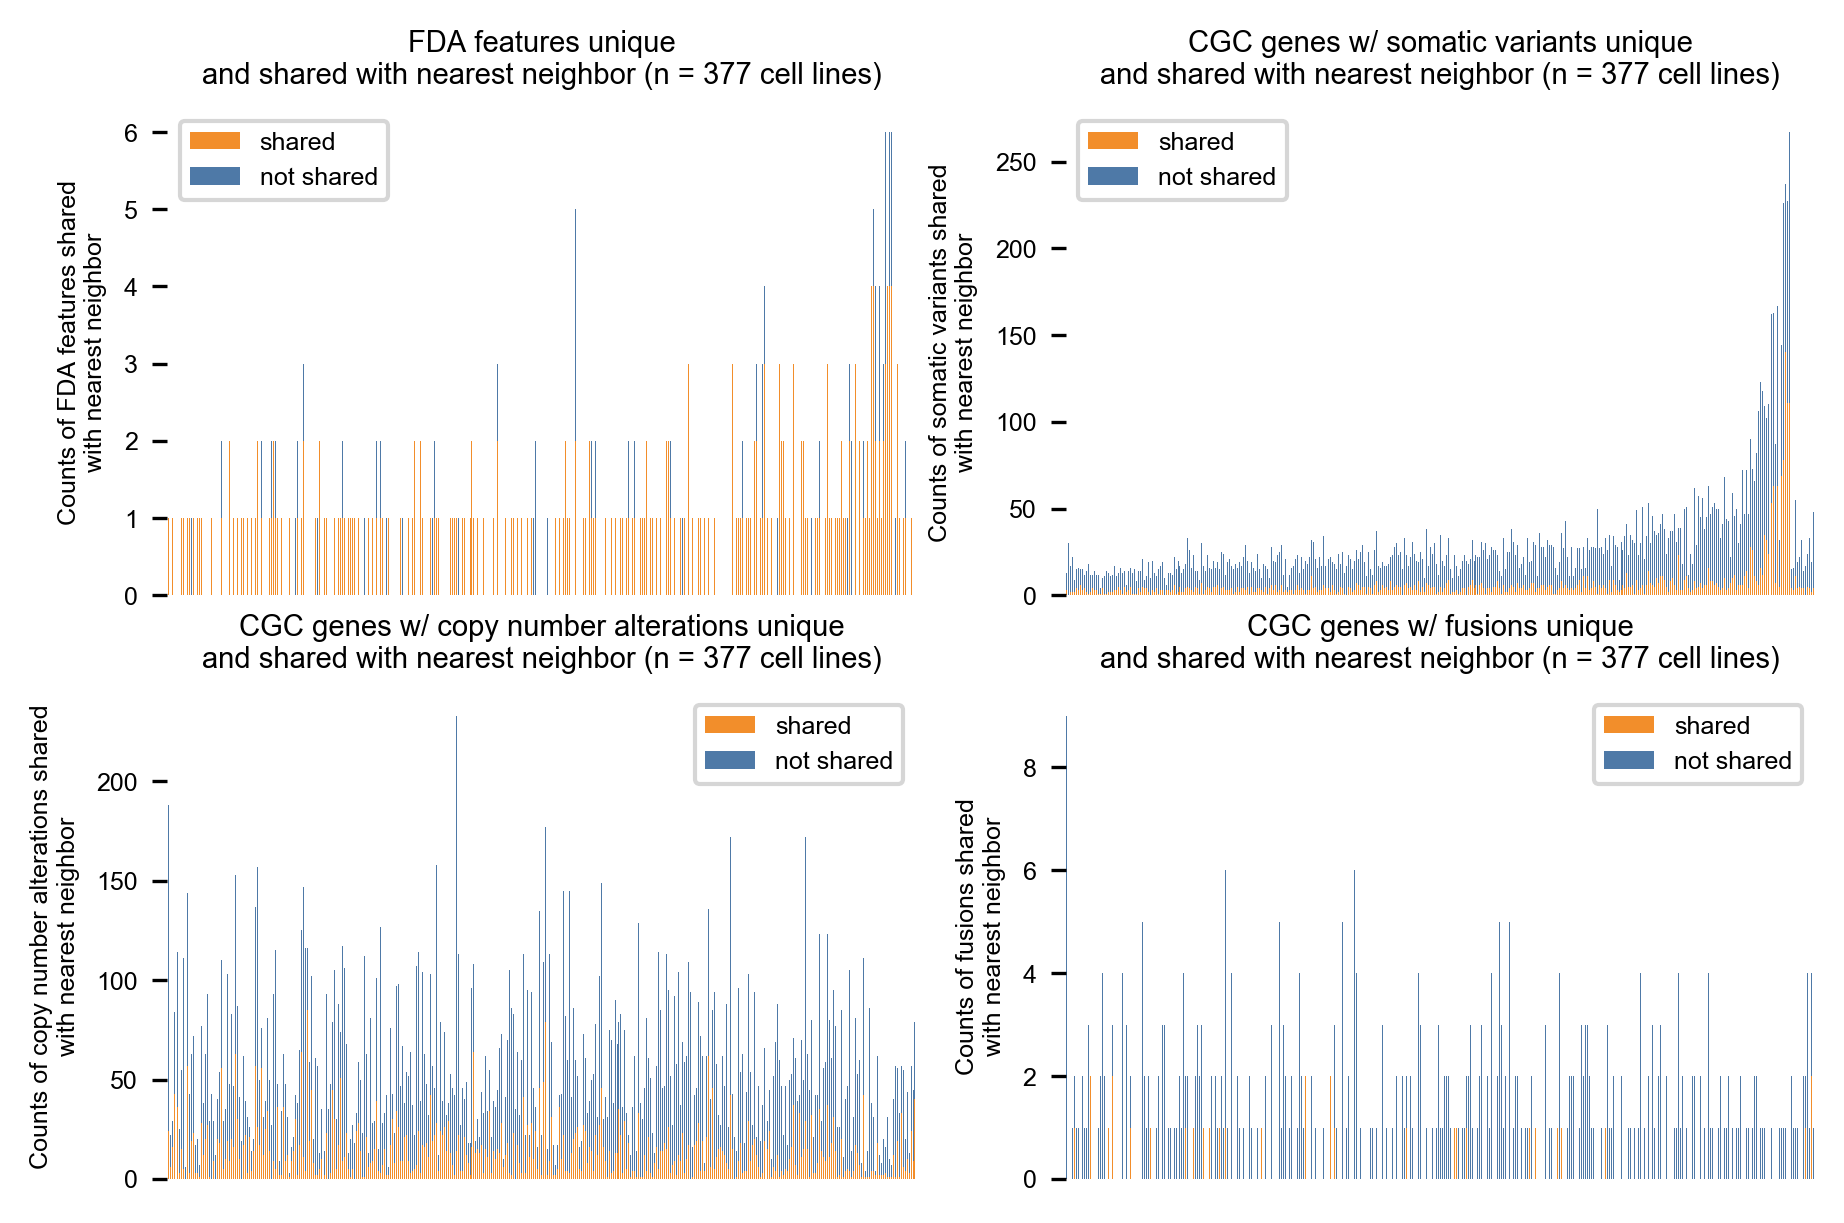

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

BLUE = '#4e79a7'
ORANGE = '#f28e2b'

cm = 1/2.54
fig = plt.figure(figsize=(18*cm, 12*cm), dpi=300)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

f_ax1 = fig.add_subplot(spec[0, 0])
p1 = df.loc[:, 'n_fda_shared_w_neighbor'].plot.bar(ax=f_ax1, color=ORANGE, label='shared')
p2 = df.loc[:, 'n_fda'].subtract(df.loc[:, 'n_fda_shared_w_neighbor']).plot.bar(ax=f_ax1, bottom=df.loc[:, 'n_fda_shared_w_neighbor'], color=BLUE, label='not shared')
f_ax1.axes.get_xaxis().set_visible(False)
f_ax1.set_title('FDA features unique\nand shared with nearest neighbor (n = 377 cell lines)', fontsize=7)
plt.legend(fontsize=6)
plt.ylabel('Counts of FDA features shared\nwith nearest neighbor', fontsize=6)

f_ax2 = fig.add_subplot(spec[0, 1])
p3 = df.loc[:, 'n_somatic_shared_w_neighbor'].plot.bar(ax=f_ax2, color=ORANGE, label='shared')
p4 = df.loc[:, 'n_somatic'].subtract(df.loc[:, 'n_somatic_shared_w_neighbor']).plot.bar(ax=f_ax2, bottom=df.loc[:, 'n_somatic_shared_w_neighbor'], color=BLUE, label='not shared')
f_ax2.axes.get_xaxis().set_visible(False)
f_ax2.set_title('CGC genes w/ somatic variants unique\nand shared with nearest neighbor (n = 377 cell lines)', fontsize=7)
plt.ylabel('Counts of somatic variants shared\nwith nearest neighbor', fontsize=6)
plt.legend(fontsize=6)

f_ax3 = fig.add_subplot(spec[1, 0])
p5 = df.loc[:, 'n_cn_shared_w_neighbor'].plot.bar(ax=f_ax3, color=ORANGE, label='shared')
p6 = df.loc[:, 'n_cn'].subtract(df.loc[:, 'n_cn_shared_w_neighbor']).plot.bar(ax=f_ax3, bottom=df.loc[:, 'n_cn_shared_w_neighbor'], color=BLUE, label='not shared')
f_ax3.axes.get_xaxis().set_visible(False)
f_ax3.set_title('CGC genes w/ copy number alterations unique\nand shared with nearest neighbor (n = 377 cell lines)', fontsize=7)
plt.ylabel('Counts of copy number alterations shared\nwith nearest neighbor', fontsize=6)
plt.legend(fontsize=6)

f_ax4 = fig.add_subplot(spec[1, 1])
p7 = df.loc[:, 'n_fusion_shared_w_neighbor'].plot.bar(ax=f_ax4, color=ORANGE, label='shared')
p8 = df.loc[:, 'n_fusion'].subtract(df.loc[:, 'n_fusion_shared_w_neighbor']).plot.bar(ax=f_ax4, bottom=df.loc[:, 'n_fusion_shared_w_neighbor'], color=BLUE, label='not shared')
f_ax4.axes.get_xaxis().set_visible(False)
f_ax4.set_title('CGC genes w/ fusions unique\nand shared with nearest neighbor (n = 377 cell lines)', fontsize=7)
plt.ylabel('Counts of fusions shared\nwith nearest neighbor', fontsize=6)
plt.legend(fontsize=6)

def remove_spines(ax):
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

for ax in [f_ax1, f_ax2, f_ax3, f_ax4]:
    remove_spines(ax)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.tick_params(axis='both', which='minor', labelsize=6)

filename = 'extended-data-fig-3'
folder = f'../../extended-data-figures/extended-data-fig-3'
!mkdir -p $folder
for suffix in ['eps', 'pdf', 'png', 'svg']:
    outname = f'{folder}/{filename}.{suffix}'
    plt.savefig(outname, format=suffix, bbox_inches='tight', dpi=300)
    
df.to_excel(f'{folder}/source-data-{filename}.xlsx', index_label='case_model',
           sheet_name='Extended Data Fig. 3')

plt.show()

In [8]:
df['n_fda'].astype(int).describe()

count    377.000000
mean       0.827586
std        1.043971
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: n_fda, dtype: float64

In [9]:
df['n_fda_shared_w_neighbor'].astype(int).describe()

count    377.000000
mean       0.663130
std        0.825487
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: n_fda_shared_w_neighbor, dtype: float64

In [10]:
df['n_fda_shared_w_neighbor'].median()

0.0

In [11]:
df['n_fda'].median()

1.0

## What is the fraction of total somatic variants, rearrangements, and copy number alterations shared between nearest neighbors?

In [12]:
df.head()

,comparison,n_fda,n_fda_shared_w_neighbor,n_somatic,n_somatic_shared_w_neighbor,n_cn,n_cn_shared_w_neighbor,n_fusion,n_fusion_shared_w_neighbor,n
case,,,,,,,,,,
ACH-000001,ACH-000893,1,1,13,3,188,24,9,0,211
ACH-000007,ACH-000504,0,0,30,0,22,6,0,0,52
ACH-000008,ACH-000450,1,1,17,2,29,16,0,0,47
ACH-000009,ACH-000759,0,0,22,2,84,43,1,0,107
ACH-000012,ACH-000491,3,2,9,2,15,3,2,1,29


In [13]:
columns_total = ['n_somatic', 'n_cn', 'n_fusion']
columns_neighbors = ['n_somatic_shared_w_neighbor', 'n_cn_shared_w_neighbor', 'n_fusion_shared_w_neighbor']
df.loc[:, columns_total].sum(axis=1).describe()

count    377.000000
mean      88.066313
std       44.630318
min       11.000000
25%       55.000000
50%       79.000000
75%      113.000000
max      274.000000
dtype: float64

In [14]:
df.loc[:, columns_total].sum(axis=1).median()

79.0

In [15]:
df.loc[:, columns_neighbors].sum(axis=1).describe()

count    377.000000
mean      21.034483
std       17.446922
min        2.000000
25%        9.000000
50%       17.000000
75%       26.000000
max      141.000000
dtype: float64

In [16]:
df.loc[:, columns_neighbors].sum(axis=1).median()

17.0

In [17]:
df.loc[:, columns_neighbors].sum(axis=1).divide(df.loc[:, columns_total].sum(axis=1)).describe()

count    377.000000
mean       0.237613
std        0.126351
min        0.023077
25%        0.142857
50%        0.225000
75%        0.310345
max        0.685185
dtype: float64

In [18]:
for dtype in ['somatic', 'cn', 'fusion']:
    tmp = df.loc[:, f'n_{dtype}_shared_w_neighbor'].divide(df.loc[:, f'n_{dtype}'])
    print(dtype)
    print(tmp.median())
    print(tmp.astype(float).describe())
    print('')

somatic
0.18181818181818182
count    377.000000
mean       0.191874
std        0.098788
min        0.000000
25%        0.121212
50%        0.181818
75%        0.250000
max        0.590717
dtype: float64

cn
0.24242424242424243
count    377.000000
mean       0.259363
std        0.185723
min        0.000000
25%        0.105263
50%        0.242424
75%        0.358974
max        0.857143
dtype: float64

fusion
0.0
count    221.000000
mean       0.098039
std        0.279684
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
dtype: float64



In [19]:
df['n_somatic'].median()

22.0

In [20]:
df['n_fusion'].median()

1.0

In [21]:
df['n_cn'].median()

48.0

In [22]:
df['n_fda'].median()

1.0

In [23]:
w_fda = df[~df['n_fda'].eq(0)]
wo_fda = df[df['n_fda'].eq(0)]
print(w_fda.shape[0], wo_fda.shape[0])

205 172


In [24]:
print(w_fda['n_fda'].mean(), w_fda['n_fda'].max(), w_fda['n_fda'].std())

1.5219512195121951 6 0.9730466091052128


In [25]:
w_fda['n_fda_shared_w_neighbor'].divide(w_fda['n_fda']).median()

1.0

In [26]:
w_fda['n_fda_shared_w_neighbor'].divide(w_fda['n_fda']).value_counts()

1.000000    154
0.500000     22
0.000000     17
0.666667      8
0.333333      1
0.800000      1
0.750000      1
0.400000      1
dtype: int64

In [27]:
154/205

0.751219512195122

### For the FDA approvals that are not 

In [28]:
fda_not_shared = df[~df['n_fda'].eq(0) & df['n_fda_shared_w_neighbor'].eq(0)]
for dtype in ['somatic', 'cn', 'fusion']:
    tmp = fda_not_shared.loc[:, f'n_{dtype}_shared_w_neighbor'].divide(fda_not_shared.loc[:, f'n_{dtype}'])
    print(dtype)
    print(tmp.median())
    print(tmp.astype(float).describe())
    print('')

somatic
0.1702127659574468
count    17.000000
mean      0.184398
std       0.075493
min       0.086957
25%       0.133333
50%       0.170213
75%       0.208333
max       0.312500
dtype: float64

cn
0.13636363636363635
count    17.000000
mean      0.226606
std       0.211358
min       0.008929
25%       0.071429
50%       0.136364
75%       0.333333
max       0.714286
dtype: float64

fusion
0.0
count    14.000000
mean      0.214286
std       0.425815
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
dtype: float64



### Those w/o an approval

In [29]:
for dtype in ['somatic', 'cn', 'fusion']:
    tmp = wo_fda.loc[:, f'n_{dtype}_shared_w_neighbor'].divide(wo_fda.loc[:, f'n_{dtype}'])
    print(dtype)
    print(tmp.median())
    print(tmp.astype(float).describe())
    print('')

somatic
0.17752100840336135
count    172.000000
mean       0.186210
std        0.097334
min        0.000000
25%        0.110119
50%        0.177521
75%        0.250000
max        0.500000
dtype: float64

cn
0.2922201138519924
count    172.000000
mean       0.308707
std        0.188284
min        0.000000
25%        0.182467
50%        0.292220
75%        0.418575
max        0.807692
dtype: float64

fusion
0.0
count    89.000000
mean      0.170412
std       0.355315
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
dtype: float64

